Vocabulary size: 94
Character set: !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~

Sample of sequence (first 50 characters):
(#GPl,O4nt$CdZCLw,+HM)O<-.6eQm-D~O3gj"64E,6(LmGyQj
Training on cuda
Epoch 1, Average Loss: 3.9178
Epoch 2, Average Loss: 2.8249
Epoch 3, Average Loss: 1.9033
Epoch 4, Average Loss: 1.3198
Epoch 5, Average Loss: 1.0211
Epoch 6, Average Loss: 0.8713
Epoch 7, Average Loss: 0.7849
Epoch 8, Average Loss: 0.7291
Epoch 9, Average Loss: 0.6910
Epoch 10, Average Loss: 0.6638


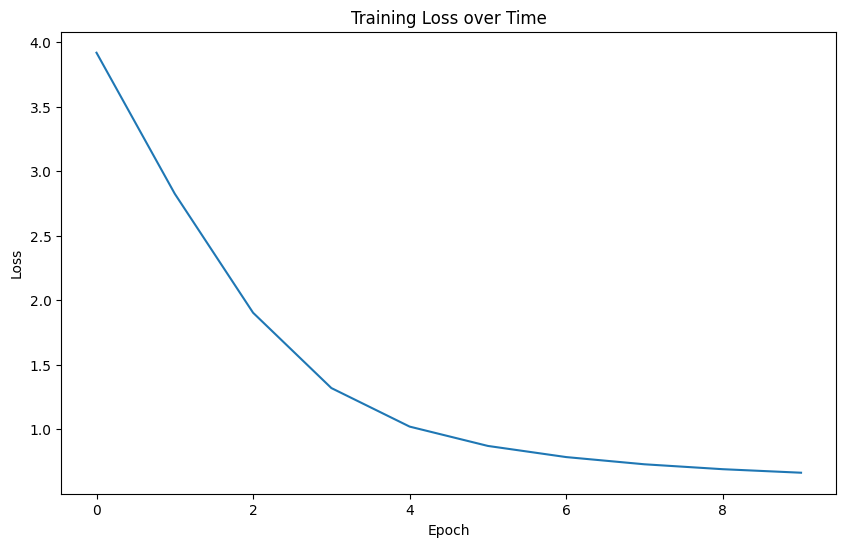


Sample prediction:
Input: Hello!
Output: HHHHwe


In [5]:
import torch
import random
import string
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# First generate the sequence
def generate_char_sequence(length=4000, vocab_size=128):
    chars = []
    chars.extend(string.ascii_letters)
    chars.extend(string.digits)
    special_chars = string.punctuation
    chars.extend(special_chars[:vocab_size - len(chars)])
    chars = chars[:vocab_size]
    
    sequence = ''.join(random.choice(chars) for _ in range(length))
    print(f"Vocabulary size: {len(chars)}")
    print("Character set:", ''.join(sorted(set(chars))))
    return sequence

# Generate the sequence
sequence = generate_char_sequence(4000, 128)
print("\nSample of sequence (first 50 characters):")
print(sequence[:50])

# Create character mappings
char_to_idx = {char: idx for idx, char in enumerate(sorted(set(sequence)))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Create dataset
class CharacterDataset(torch.utils.data.Dataset):
    def __init__(self, text, char_to_idx, sequence_length=50):
        self.data = torch.tensor([char_to_idx[char] for char in text], dtype=torch.long)
        self.sequence_length = sequence_length
        
    def __len__(self):
        return len(self.data) - self.sequence_length - 1
        
    def __getitem__(self, idx):
        input_seq = self.data[idx:idx + self.sequence_length]
        target_seq = self.data[idx + 1:idx + self.sequence_length + 1]
        return input_seq, target_seq

# Create the model
class CharacterTransformer(torch.nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=8, num_layers=3):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dim_feedforward=512,
            batch_first=True
        )
        self.transformer = torch.nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = torch.nn.Linear(d_model, vocab_size)
        
    def forward(self, src):
        src = self.embedding(src) * torch.sqrt(torch.tensor(128.0))
        src = self.pos_encoder(src)
        output = self.transformer(src)
        output = self.fc(output)
        return output

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Training function
def train_model(model, text, char_to_idx, num_epochs=10, batch_size=64, sequence_length=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    dataset = CharacterDataset(text, char_to_idx, sequence_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    losses = []
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        
        for batch_data, batch_targets in dataloader:
            batch_data = batch_data.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad()
            output = model(batch_data)
            
            loss = criterion(output.view(-1, output.size(-1)), batch_targets.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')
    
    # Plot loss curve
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return model

# Initialize and train the model
vocab_size = len(char_to_idx)
model = CharacterTransformer(vocab_size)

# Train the model
trained_model = train_model(
    model, 
    sequence, 
    char_to_idx,
    num_epochs=10,
    batch_size=64,
    sequence_length=50
)

# Try a sample prediction
sample_text = "Hello!"
input_indices = torch.tensor([[char_to_idx[c] for c in sample_text]]).long()
trained_model.to("cpu")
trained_model.eval()
with torch.no_grad():
    output = trained_model(input_indices)
    predictions = torch.argmax(output, dim=-1)
    predicted_chars = [idx_to_char[idx.item()] for idx in predictions[0]]
    print("\nSample prediction:")
    print(f"Input: {sample_text}")
    print(f"Output: {''.join(predicted_chars)}")

In [6]:
import torch

def get_last_char_correlation(model, text, char_to_idx):
    model.eval()
    
    # Convert text to input tensor
    input_indices = torch.tensor([char_to_idx[c] for c in text], dtype=torch.long)
    input_indices = input_indices.unsqueeze(0)  # Add batch dimension
    
    # Get embeddings
    with torch.no_grad():
        # Get the embeddings
        embedded = model.embedding(input_indices)
        # Apply positional encoding
        embedded = model.pos_encoder(embedded)
        # Get transformer output
        transformer_output = model.transformer(embedded)
        # Get final output logits
        output_logits = model.fc(transformer_output)
        
        # Get probabilities for the last position
        last_pos_logits = output_logits[0, -2, :]  # -2 because we want predictions for '3'
        probs = torch.softmax(last_pos_logits, dim=0)
        
        # Get probability for '3'
        target_prob = probs[char_to_idx['3']].item()
        
    print(f"Text: {text}")
    print(f"Analyzing correlation of '3' with previous characters '{text[:-1]}'")
    print(f"Probability of '3' appearing after '{text[:-1]}': {target_prob:.4f}")
    
    # Now let's test by changing each previous character
    correlations = {}
    for i in range(len(text)-1):
        original_char = text[i]
        # Create variations by replacing each character
        total_variation = 0
        variations_tested = 0
        for test_char in char_to_idx.keys():
            if test_char == original_char:
                continue
                
            # Create modified text
            modified_text = list(text)
            modified_text[i] = test_char
            modified_text = ''.join(modified_text)
            
            # Get prediction for modified text
            input_indices = torch.tensor([char_to_idx[c] for c in modified_text], dtype=torch.long)
            input_indices = input_indices.unsqueeze(0)
            
            with torch.no_grad():
                embedded = model.embedding(input_indices)
                embedded = model.pos_encoder(embedded)
                transformer_output = model.transformer(embedded)
                output_logits = model.fc(transformer_output)
                last_pos_logits = output_logits[0, -2, :]
                probs = torch.softmax(last_pos_logits, dim=0)
                new_prob = probs[char_to_idx['3']].item()
                
                variation = abs(new_prob - target_prob)
                total_variation += variation
                variations_tested += 1
        
        # Average variation when this character is changed
        avg_variation = total_variation / variations_tested
        correlations[original_char] = avg_variation
    
    # Print correlations
    print("\nCorrelation strength with '3' (higher means stronger correlation):")
    for char, strength in sorted(correlations.items(), key=lambda x: x[1], reverse=True):
        print(f"'{char}': {strength:.4f}")

# Test the correlation
sample_text = "Hello123"
get_last_char_correlation(model, sample_text, char_to_idx)

Text: Hello123
Analyzing correlation of '3' with previous characters 'Hello12'
Probability of '3' appearing after 'Hello12': 0.0336

Correlation strength with '3' (higher means stronger correlation):
'2': 0.0694
'1': 0.0279
'H': 0.0244
'o': 0.0217
'e': 0.0212
'l': 0.0179
